## Homework Natural Language Processing

In deze notebook ga je een **sentiment analyse** doen op de reviews die bezoekers op Trip Advisor achterlieten na het bezoeken van 1 van de pretparken van Disney. Ga experimenteel na hoe je een goed voorspellend model kan bouwen om het sentiment van een review te voorspellen, puur aan de hand van de woorden (features) in de review. 

Je bouwt deze notebook __stap per stap op__. Voorzie volgende onderdelen in je notebook :

- Stap 1 : data inlezen en voorbereiden
- Stap 2 : NLP pipeline *(zie ook theorie)*
- Stap 3 : Model opstellen: Experimenteer met volgende 3 methodes
    * Gebruik de NLTK library & Vader 
    * Gebruik een Bag-of-Words approach in combinatie met een klassiek ML algoritme
    * Gebruik een RNN model
- Stap 4 : Conclusie

Voorzie tevens in elke stap een __woordje uitleg over de keuzes__ die je maakt en de __resultaten__ die je hiermee bekomt. 
</br>Geef ook een vergelijking tussen de 3 methodes.

<img src="img/disneyland.jpeg" alt="Disneyland"
	title="Disneyland" width="800" height="400" />

De **verbetersleutel** ziet er als volgt uit:


|  Stap    | #punten | 
|-----------|:--------:|
|  Stap 1: |     /1   |  
|  Stap 2: |     /4   |  
|  Stap 3: |        |  
|  ---> 3.1 |     /2    |  
|  ---> 3.2 |      /4| 
|  ---> 3.3 |      /4   |  
| Stap 4:|     /2    |
| Rapportering :|     /3   |  
|      Totaal: |     /20    | 


### Praktische afspraken:
Dit project wordt ingediend door deze notebook verder thuis af te werken en te uploaden op Toledo voor de start van je labo in **de week van maandag 10 januari 2022**

#### Alvast veel succes!

### Stap 1 : data inladen

De data bestaat uit een .csv file die rechtstreeks ingeladen kan worden. De belangrijkste kolommen zijn uiteraard de _Review_text_ en de _Rating_ kolom. De ratings gaan van een waarde 1 tot 5, waarbij 5 uitstekend is (heel positieve review) en 1 een slechte review. </br>Modeleer hieruit een classificatieprobleem (je hoeft zeker geen 5 klassen te behouden, herwerk bvb naar een binaire classificatie of eventueel naar een probleem met 3 klassen (positief neutraal, negatief).

Ga na of er waarden ontbreken, zo ja verwijder deze data.
Ga na hoeveel data je per categorie hebt. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS    

nltk.download(['stopwords', 'vader_lexicon', 'punkt'])

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/louisdhont/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/louisdhont/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/louisdhont/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('../data/DisneylandReviews.csv', encoding='latin-1')
df.sample(5)

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
19444,266378106,4,2015-3,United Kingdom,Of course there were lines to go on the popula...,Disneyland_California
34130,367255494,5,2016-4,United Kingdom,was sceptical about my enjoyment of disney wen...,Disneyland_Paris
38178,208869735,5,2013-10,United Kingdom,I absolutely loved Disneyland Paris. We were a...,Disneyland_Paris
16078,356384794,3,2016-3,United States,Ridiculously expensive for a park that is und...,Disneyland_California
25810,141117068,5,2012-9,United States,We had a fantastic time at Disneyland during t...,Disneyland_California


Na het inlezen worden de dubbele waarden verwijderd en uitgeprint.

In [3]:
df.drop_duplicates(subset='Review_ID', inplace=True, keep='first')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42636 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42636 non-null  int64 
 1   Rating             42636 non-null  int64 
 2   Year_Month         42636 non-null  object
 3   Reviewer_Location  42636 non-null  object
 4   Review_Text        42636 non-null  object
 5   Branch             42636 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.3+ MB


Alle lege velden worden ook verwijderd zodat er enkel zinvolle data wordt gebruikt.

In [5]:
df = df.dropna().reset_index()
print('Missing values: ', df.isnull().sum().values.sum())
df.head()

Missing values:  0


,index,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


Enkel de Reviews teksten, rating en branch is op dit moment interessant om verder mee aan de slag te gaan.

In [6]:
df.drop(columns=['index', 'Review_ID', 'Year_Month', 'Reviewer_Location'], inplace=True)

In [7]:
print ('Rows     : ', df.shape[0])
print ('Columns  : ', df.shape[1])
print ('\nFeatures : \n', df.columns.tolist())
print ('\nMissing values: ', df.isnull().sum().values.sum())
print ('Unique values:\n', df.nunique())

Rows     :  42636
Columns  :  3

Features : 
 ['Rating', 'Review_Text', 'Branch']

Missing values:  0
Unique values:
 Rating             5
Review_Text    42624
Branch             3
dtype: int64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42636 entries, 0 to 42635
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Rating       42636 non-null  int64 
 1   Review_Text  42636 non-null  object
 2   Branch       42636 non-null  object
dtypes: int64(1), object(2)
memory usage: 999.4+ KB


Ter informatie wordt hieronder een review tekst uitgeprint.

In [9]:
df['Review_Text'].values[2:3]

array(['Thanks God it wasn   t too hot or too humid when I was visiting the park   otherwise it would be a big issue (there is not a lot of shade).I have arrived around 10:30am and left at 6pm. Unfortunately I didn   t last until evening parade, but 8.5 hours was too much for me.There is plenty to do and everyone will find something interesting for themselves to enjoy.It wasn   t extremely busy and the longest time I had to queue for certain attractions was 45 minutes (which is really not that bad).Although I had an amazing time, I felt a bit underwhelmed with choice of rides and attractions. The park itself is quite small (I was really expecting something grand   even the main castle which was closed by the way was quite small).The food options are good, few coffee shops (including Starbucks) and plenty of gift shops. There was no issue with toilets as they are everywhere.All together it was a great day out and I really enjoyed it.'],
      dtype=object)

In [10]:
df.head()

,Rating,Review_Text,Branch
0,4,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,4,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,4,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,4,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,4,"the location is not in the city, took around 1...",Disneyland_HongKong


Hoe zijn de scores verdeeld? In het onderstaande lijstje worden de aantallen weergegeven. Hieruit kunnen we duidelijk zien dat het grootste aantal scores een 4 en 5 zijn.

In [11]:
rating_count = df.Rating.value_counts()
rating_count

5    23137
4    10768
3     5105
2     2127
1     1499
Name: Rating, dtype: int64

Het aantal reviews per branch worden ook uitgeprint ter informatie. Hieruit komen ook het meeste aantal reviews uit California en Parijs.

In [12]:
df['Branch'].value_counts().sort_values(ascending=False)

Disneyland_California    19400
Disneyland_Paris         13629
Disneyland_HongKong       9607
Name: Branch, dtype: int64

De gemiddelde score die de mensen gaven is 4.21 op 5.

In [13]:
df['Rating'].mean()

4.217679894924477

Hieronder zijn de gemiddelde scores te zien voor elke Disneyland branch.

In [14]:
df.groupby('Branch')['Rating'].mean().sort_values(ascending=False)

Branch
Disneyland_California    4.405361
Disneyland_HongKong      4.204226
Disneyland_Paris         3.960012
Name: Rating, dtype: float64

Deze bar grafiek toont het aantal reviews per score. Hieruit blijkt dat een 5/5 score het meest domineert in de scores wat meer dan de helft van de scores is.

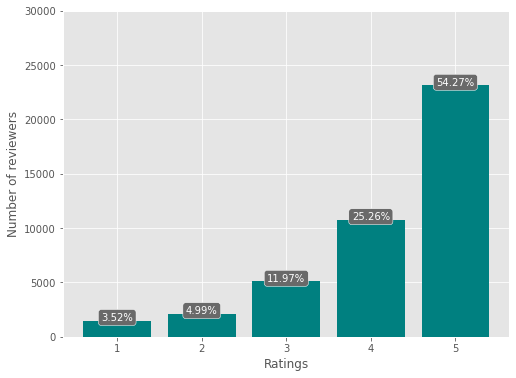

In [15]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(8, 6))
    plt.bar(rating_count.index, rating_count.values, color='teal')
    for r, val in zip(rating_count.index, rating_count.values):
        plt.text(r, val, 
                 str(round(val / sum(rating_count.values) * 100, 2)) + '%', 
                 ha = 'center', color='white', 
                 bbox = dict(facecolor='dimgrey', edgecolor='white', boxstyle='round'))
    plt.xlabel('Ratings')
    plt.ylabel('Number of reviewers')
    plt.yticks(np.arange(0, 30001, 5000))

Deze onderstaande grafiek toont het aantal reviews per branches.

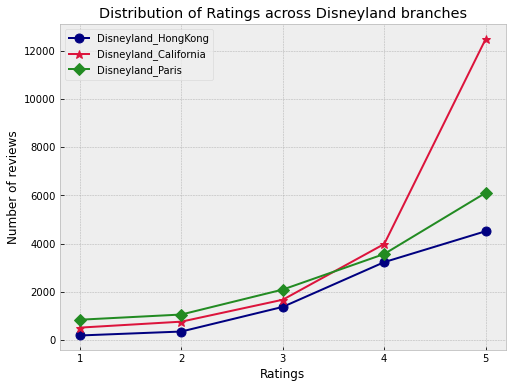

In [16]:
markers = ['o', '*', 'D']
branch_col = ['navy', 'crimson', 'forestgreen']
with plt.style.context('bmh'):
    plt.figure(figsize=(8, 6))
    for branch, m, col in zip(df.Branch.unique(), markers, branch_col):
        counts = df[df.Branch == branch]['Rating'].value_counts()
        x = counts.index
        y = counts.values
        plt.plot(x, y, marker=m, markersize=9, color=col, label=branch)
        plt.xticks(np.arange(1, 6))
        plt.xlabel('Ratings')
        plt.ylabel('Number of reviews')
    plt.title('Distribution of Ratings across Disneyland branches')
    plt.legend()
    plt.show()

Om de modellen te trainen is het eenvoudiger te clasificeren door de 1-5 scores om te vormen tot een positief, negatief en neutraal waarde, gerepresenteerd door 0, 1 en 2. In dit geval zijn scores 4 en 5 positief, 1 en 2 negatief met 3 als neutraal. 

In [17]:
pos = [4, 5]
neg = [1, 2]
neu = [3]

def sentiment(rating):
    if rating in pos:
        return 2
    elif rating in neg:
        return 0
    else:
        return 1  
df['Sentiment'] = df['Rating'].apply(sentiment)
df.head()

,Rating,Review_Text,Branch,Sentiment
0,4,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2
1,4,Its been a while since d last time we visit HK...,Disneyland_HongKong,2
2,4,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2
3,4,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2
4,4,"the location is not in the city, took around 1...",Disneyland_HongKong,2


De lijst van stopwoorden wordt gebruikt om later de teksten te processen.

In [18]:
stopwords = set(STOPWORDS)
stopwords.update(['park', 'parks', 'ride', 'rides', 'Disney', 'Disneyland'])

In onderstaande figuur worden de woorden weergegeven in een word cloud waarbij hoe groter een woord is hoe vaker het voorkomt in de teksten. Hieruit zien we dat er heel wat woorden zoals 'great', 'attraction', 'people', first', 'queue'... gebruikt worden.

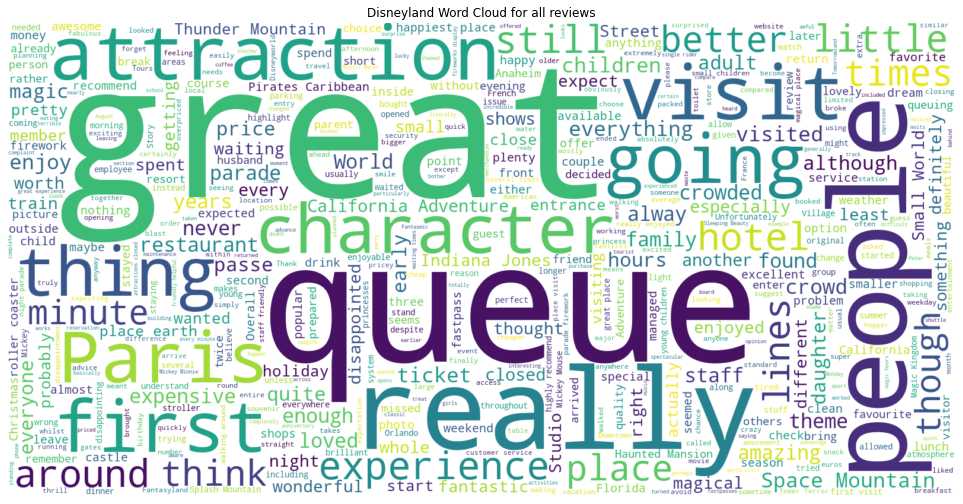

In [19]:
text = ' '.join(review for review in df.Review_Text)

plt.figure(figsize=(17, 17))
wc = WordCloud(stopwords=stopwords, max_words=500, width=1600, height=800, min_word_length=5, background_color='white').generate(text)
plt.title('Disneyland Word Cloud for all reviews')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off');

In [21]:
### Separate Disneyland dataframes into there scores
score_1 = df.loc[df['Rating'] == 1]
score_2 = df.loc[df['Rating'] == 2]
score_3 = df.loc[df['Rating'] == 3]
score_4 = df.loc[df['Rating'] == 4]
score_5 = df.loc[df['Rating'] == 5]

Om meer inzicht te krijgen in de woorden kunnen we een word cloud maken voor elke score. Hieruit kunnen we zien dat de lagere scores (1, 2, 3) vaak het woord 'queue' (wachtrij) en 'people' (mensen) vertonen wat aangeeft dat er waarschijnlijk negatief gesproken wordt over wachtrijen en dergelijke. Bij de meer positieve scores komen dan meer woorden zoals 'great', 'attraction', 'visit' gebruikt worden in de reviews, wat aanduidt dat het positieve reviews zijn.

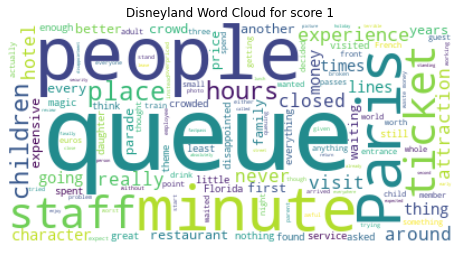

In [22]:
text1 = ' '.join(review for review in score_1.Review_Text)

plt.figure(figsize=(8, 10))
wc = WordCloud(stopwords=stopwords, max_words=500, min_word_length=5, background_color='white').generate(text1)
plt.title('Disneyland Word Cloud for score 1')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off');

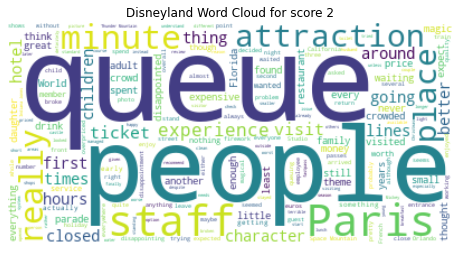

In [23]:
text2 = ' '.join(review for review in score_2.Review_Text)

plt.figure(figsize=(8, 10))
wc2 = WordCloud(stopwords=stopwords, max_words=500, min_word_length=5, background_color='white').generate(text2)
plt.title('Disneyland Word Cloud for score 2')
plt.imshow(wc2, interpolation='bilinear')
plt.axis('off');

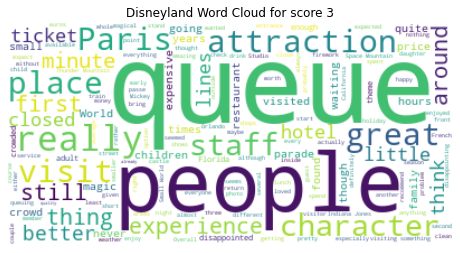

In [24]:
text3 = ' '.join(review for review in score_3.Review_Text)

plt.figure(figsize=(8, 10))
wc3 = WordCloud(stopwords=stopwords, max_words=500, min_word_length=5, background_color='white').generate(text3)
plt.title('Disneyland Word Cloud for score 3')
plt.imshow(wc3, interpolation='bilinear')
plt.axis('off');

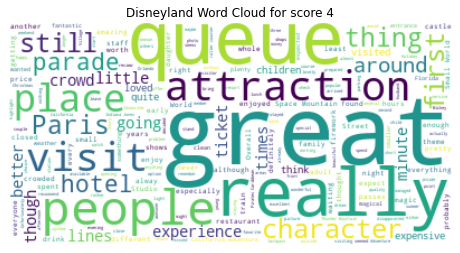

In [25]:
text4 = ' '.join(review for review in score_4.Review_Text)

plt.figure(figsize=(8, 10))
wc4 = WordCloud(stopwords=stopwords, max_words=500, min_word_length=5, background_color='white').generate(text4)
plt.title('Disneyland Word Cloud for score 4')
plt.imshow(wc4, interpolation='bilinear')
plt.axis('off');

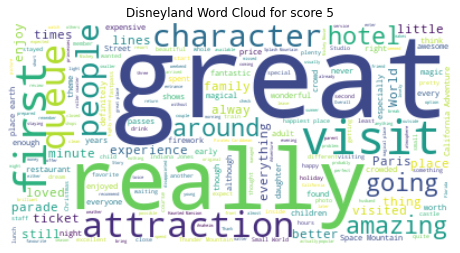

In [26]:
text5 = ' '.join(review for review in score_5.Review_Text)

plt.figure(figsize=(8, 10))
wc5 = WordCloud(stopwords=stopwords, max_words=500, min_word_length=5, background_color='white').generate(text5)
plt.title('Disneyland Word Cloud for score 5')
plt.imshow(wc5, interpolation='bilinear')
plt.axis('off');

### Stap 2 : Text Processing Pipeline

Voorzie volgende stappen. Je kan hiervoor gebruik maken van de __NLTK library in Python__ (zie bv. https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk).

De keuze voor vectorizatie kies je in de volgende stap, die keuze is immers afhankelijk van hoe je de uitwerking gaat doen).
Uiteindelijk moet elke review vertaald worden naar een zin waarin volgende aanpassingen gebeuren :

1. **Tokenization**: split elke review in woorden, zodat je er de volgende stappen kan op loslaten

2. **Punctuation removal** : 
      je kan volgende punctuations verwijderen uit de review : "!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
      
3. **Stopword Removal**: 
    de nltk.corpus module voorziet een lijst van stopwoorden die je kan gebruiken om te verwijderen uit de reviews:
          
        import nltk
        from nltk.corpus import stopwords
        
    Deze moet je vooraf wel downloaden bvb via cmd line : _python -m nltk.downloader stopwords_
        
4. **Lower casing / negation handling**

5. **Lemmatizing / Stemming** : Kies in deze stap voor Lemmatizing of Stemming. Voer beiden eens uit, kijk naar de verschillen en maak een keuze.
    Zowel Lemmatizing als Stemming kan je via de NLTK library uitvoeren. zie bvb. https://www.geeksforgeeks.org/python-lemmatization-with-nltk/ en https://www.geeksforgeeks.org/python-stemming-words-with-nltk/.
    Als je wordnet wil gebruiken zal je deze ook eerst moeten downloaden: 
   
    python -m nltk downloader wordnet



In [19]:
df['Original_Text'] = df['Review_Text']

### Tokenizen & Lower casing

In de kolom `tokenized` wordt voor elke review een array van woorden bijgehouden door de RegexpTokenizer te gebruiken. Alle woorden worden opgesplitst in een array en omgezet naar de kleine letter schrijfwijze. Alle leestekens, punten en dergelijke worden verwijderd omdat deze geen bijdrage leveren aan het model.

In [20]:
def tokenize(column):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(column)
    return [w.lower() for w in tokens if w.isalpha()]

df['tokenized'] = df.apply(lambda row: tokenize(row['Review_Text']), axis=1)

### Stopwords removal

Het verwijderen van stopwoorden kan mogelijk helpen de prestaties te verbeteren van het model. Aangezien er alleen zinvolle woorden (tokens) over blijven zou e nauwkeurigheid van het classificatie model kunnen vergroot worden. Dit wordt gedaan met een functie dat elk woord verwijderd uit de tokens array.

In [21]:
def remove_stopwords(tokenized_column):
    return [word for word in tokenized_column if not word in stopwords]

df['stopwords_removed'] = df.apply(lambda x: remove_stopwords(x['tokenized']), axis=1)

In [22]:
print('Tokenized text: ', df['tokenized'][19])
print()
print('With stopwords removed: ', df['stopwords_removed'][19])

Tokenized text:  ['there', 'is', 'nothing', 'more', 'to', 'say', 'except', 'that', 'you', 'become', 'a', 'child', 'once', 'again', 'as', 'you', 'step', 'inside', 'disneyland', 'in', 'hk', 'easy', 'to', 'go', 'and', 'come', 'out', 'with', 'dedicated', 'trams', 'and', 'subway', 'stations', 'wait', 'for', 'the', 'parade', 'at', 'sunset', 'it', 'is', 'definitely', 'worth', 'waiting']

With stopwords removed:  ['nothing', 'say', 'except', 'become', 'child', 'step', 'inside', 'disneyland', 'hk', 'easy', 'go', 'come', 'dedicated', 'trams', 'subway', 'stations', 'wait', 'parade', 'sunset', 'definitely', 'worth', 'waiting']


### Lemmatizing / Stemming

Om grammaticale redenen gaan documenten verschillende vormen van een woord gebruiken, zoals organiseren, georganiseerd, organiseert. Daarnaast zijn er families van afgeleide verwante woorden met vergelijkbare betekenissen. Het doel van zowel stemming als lemmatisering is om verbuigingsvormen en soms afgeleide vormen van een woord terug te brengen tot een algemene basisvorm. Hieronder wordt een voorbeeld gegeven tussen beide werkingen met als verschil dat de Porter stemmer voor minder goede resultaten komen, zo wordt het woord 'nothing' voor Porter 'not' en bij WordNetLemmatizer 'nothing' waarbij ik persoon het woord 'nothing' meer duidelijk vindt.

In [23]:
def apply_porterstemmer(tokenized_column):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in tokenized_column]

def apply_wordnetlemmatizer(tokenized_column):
    lem = WordNetLemmatizer()
    return [lem.lemmatize(word, 'v') for word in tokenized_column]

#df['porter_stemmed'] = df.apply(lambda row: apply_porterstemmer(row['stopwords_removed']), axis=1)
df['word_lemmatized'] = df.apply(lambda row: apply_wordnetlemmatizer(row['stopwords_removed']), axis=1) #porter_stemmed

lem = WordNetLemmatizer()
stem = PorterStemmer()
word = 'nothing'
print('Diffrence between Lemmatizing and Stemming for the word:', word)
print('Lemmatized Word:', lem.lemmatize(word, 'v'))
print('Porter Stemmed Word:', stem.stem(word))

Diffrence between Lemmatizing and Stemming for the word: nothing
Lemmatized Word: nothing
Porter Stemmed Word: noth


In [24]:
print('Lemmatized text: ', df['word_lemmatized'][19])

Lemmatized text:  ['nothing', 'say', 'except', 'become', 'child', 'step', 'inside', 'disneyland', 'hk', 'easy', 'go', 'come', 'dedicate', 'tram', 'subway', 'station', 'wait', 'parade', 'sunset', 'definitely', 'worth', 'wait']


Enkel de originele teksten en opgeruimde teksten kunnen worden gebruikt als data voor de modellen.

In [25]:
df.drop(columns=['stopwords_removed', 'Branch', 'tokenized', 'Review_Text'], inplace=True) #'porter_stemmed'
df.rename(columns={'word_lemmatized': 'Review_Text'}, inplace=True)
df.head()

,Rating,Sentiment,Original_Text,Review_Text
0,4,2,If you've ever been to Disneyland anywhere you...,"[ve, disneyland, anywhere, ll, find, disneylan..."
1,4,2,Its been a while since d last time we visit HK...,"[d, last, time, visit, hk, disneyland, yet, ti..."
2,4,2,Thanks God it wasn t too hot or too humid wh...,"[thank, god, wasn, t, hot, humid, visit, big, ..."
3,4,2,HK Disneyland is a great compact park. Unfortu...,"[hk, disneyland, great, compact, unfortunately..."
4,4,2,"the location is not in the city, took around 1...","[location, city, take, around, hour, kowlon, k..."


In [26]:
tokenized_words = df['Review_Text'][283]
print('Example of a tokenized review text:', tokenized_words)

Example of a tokenized review text: ['people', 'themepark', 'one', 'small', 'much', 'attractions', 'name', 'people', 'flock', 'place', 'countries', 'good', 'disney', 'one']


Om de modellen teksten te geven moeten deze als string worden aangeleverd.

In [27]:
def list_to_string(input_text): 
    str1 = ''
    for elem in input_text: 
        str1 += ' ' + elem
    return str1
df['cleaned_text'] = df.apply(lambda row: list_to_string(row['Review_Text']), axis=1) #porter_stemmed

### Stap 3 : Sentiment analysis 

Ga na wat de kwaliteit is van Sentiment analyse op de reviews via volgende 3 technieken :

1. Gebruik de ingebouwde sentiment analyzer VADER (Valence Aware Dictionary end sEntiment Reasoner) van de NLTL library (Zie ook: https://realpython.com/python-nltk-sentiment-analysis).

2. Gebruik een Bag-of-Words techniek via CountVectorizer en TFIDFVectorizer. Gebruik na deze vectorizatie een klassiek classificatie-algoritme om je data te trainen en testen (Zie ook: https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/ of https://vitalflux.com/text-classification-bag-of-words-model-python-sklearn/).

3. Gebruik een deep learning RNN en TensorFlow/Keras om je sentiment voorspeller te bouwen. Hieronder vind je enkele voorbeelden waaruit je inspiratie kan opdoen.

### Inspiratie files


- Text classification with RNN : https://www.tensorflow.org/text/tutorials/text_classification_rnn
- RNN with Keras (https://www.tensorflow.org/text/tutorials/text_classification_rnn)
- https://www.kaggle.com/abhimanyu314/tripadvisor-rnn
- https://www.kaggle.com/deepakvedantam/imdb-review-sentimental-analysis-with-keras
- https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

# VADER analyse

Als eerste model wordt het VADER (Valence Aware Dictionary for Sentiment Reasoning) model gebruikt. Vader is een model dat tekst sentimentanalyse uitvoerd en gevoelig is voor zowel polariteit (positief/negatief) als intensiteit (sterkte) van emotie.

Als resultaat van een tekst worden vier sentimentscores terug gegeven. De eerste drie: pos, neutraal en neg, hebben betrekking op de omvang van de inhoud die in die classificaties valt. De laatste (4de) meting, de samengestelde score (compound score), is het totale aantal lexiconcijfers die genormaliseerd zijn om te lopen tussen –1 en 1.

In [36]:
vaderdf = df.copy()
vaderdf.drop(columns=['Original_Text', 'Review_Text'], inplace=True)
vaderdf

,Rating,Sentiment,cleaned_text
0,4,2,ve disneyland anywhere ll find disneyland hon...
1,4,2,d last time visit hk disneyland yet time stay...
2,4,2,thank god wasn t hot humid visit big issue lo...
3,4,2,hk disneyland great compact unfortunately qui...
4,4,2,location city take around hour kowlon kid dis...
...,...,...,...
42631,5,2,go disneyland paris july think brilliant visi...
42632,5,2,adults child visit disneyland paris begin feb...
42633,5,2,eleven year old daughter go visit son london ...
42634,4,2,hotel part disneyland paris complex wonderful...


In onderstaande lijst worden de scores voor de eerste en laatste 5 reviews getoond.

In [37]:
sid = SentimentIntensityAnalyzer()

vaderdf['score'] = vaderdf['cleaned_text'].apply(lambda review: sid.polarity_scores(review))
vaderdf['score']

0        {'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'comp...
1        {'neg': 0.074, 'neu': 0.664, 'pos': 0.262, 'co...
2        {'neg': 0.069, 'neu': 0.57, 'pos': 0.361, 'com...
3        {'neg': 0.104, 'neu': 0.657, 'pos': 0.239, 'co...
4        {'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp...
                               ...                        
42631    {'neg': 0.0, 'neu': 0.701, 'pos': 0.299, 'comp...
42632    {'neg': 0.02, 'neu': 0.598, 'pos': 0.382, 'com...
42633    {'neg': 0.039, 'neu': 0.729, 'pos': 0.232, 'co...
42634    {'neg': 0.0, 'neu': 0.75, 'pos': 0.25, 'compou...
42635    {'neg': 0.026, 'neu': 0.713, 'pos': 0.261, 'co...
Name: score, Length: 42636, dtype: object

In [38]:
vaderdf['comp_score'] = vaderdf['score'].apply(lambda d:d['compound'])
vaderdf['comp_score']

0        0.7889
1        0.9738
2        0.9838
3        0.8316
4        0.2023
          ...  
42631    0.9819
42632    0.9885
42633    0.8979
42634    0.9517
42635    0.9743
Name: comp_score, Length: 42636, dtype: float64

In [39]:
vaderdf.head()

,Rating,Sentiment,cleaned_text,score,comp_score
0,4,2,ve disneyland anywhere ll find disneyland hon...,"{'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'comp...",0.7889
1,4,2,d last time visit hk disneyland yet time stay...,"{'neg': 0.074, 'neu': 0.664, 'pos': 0.262, 'co...",0.9738
2,4,2,thank god wasn t hot humid visit big issue lo...,"{'neg': 0.069, 'neu': 0.57, 'pos': 0.361, 'com...",0.9838
3,4,2,hk disneyland great compact unfortunately qui...,"{'neg': 0.104, 'neu': 0.657, 'pos': 0.239, 'co...",0.8316
4,4,2,location city take around hour kowlon kid dis...,"{'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp...",0.2023


In [40]:
vaderdf.groupby('Sentiment')['comp_score'].describe()

,count,mean,std,min,25%,50%,75%,max
Sentiment,,,,,,,,
0,3626.0,0.294173,0.658436,-0.9891,-0.2960,0.5423,0.89075,0.9988
1,5105.0,0.583362,0.504233,-0.9801,0.4116,0.8176,0.94460,0.9992
2,33905.0,0.803876,0.291225,-0.9899,0.7845,0.9169,0.96780,0.9999


De gemiddelde compound score is 73.41%. Hieronder staan ook de compound gemiddeldde scores per sentiment waarde uitgedrukt.

In [41]:
print(vaderdf.groupby('Sentiment')['comp_score'].mean() * 100)
print()
print('Overall compound score: {}%'.format(str(round(vaderdf['comp_score'].mean() * 100, 2))))

Sentiment
0    29.417300
1    58.336202
2    80.387558
Name: comp_score, dtype: float64

Overall compound score: 73.41%


In onderstaande output staan het aantal in procent uitgedrukt voor elk sentiment. Hieruit kunnen we zien dat het meeste aantal van de reviews een postieve of neutrale score krijgt. Vaak worden de positieve scores als neutraal aangegeven volgens het VADER model.

In [42]:
neg_polarity = 0
pos_polarity = 0
neutral_polarity = 0

for results in vaderdf['score']:
    neg_polarity += results['neg']
    pos_polarity += results['pos']
    neutral_polarity += results['neu']
    
neg_polarity = neg_polarity / len(vaderdf)
pos_polarity = pos_polarity / len(vaderdf)
neutral_polarity = neutral_polarity / len(vaderdf)

print('Negative score : {}%'.format(str(round(neg_polarity * 100, 2))))
print('Positive score : {}%'.format(str(round(pos_polarity * 100, 2))))
print('Neutral score  : {}%'.format(str(round(neutral_polarity * 100, 2))))

Negative score : 5.81%
Positive score : 30.07%
Neutral score  : 64.12%


In deze grafiek worden de eerste 50 compount scores weergegeven. Hieruit kunnen we zien dat de meerderheid van de scores boven de positieve 50% liggen.

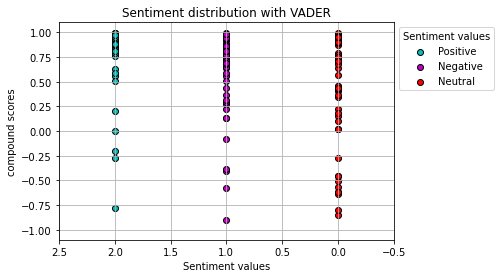

In [45]:
pos = vaderdf.loc[vaderdf['Sentiment'] == 2].head(50)
neg = vaderdf.loc[vaderdf['Sentiment'] == 1].head(50)
neu = vaderdf.loc[vaderdf['Sentiment'] == 0].head(50)

plt.scatter(pos['Sentiment'], pos['comp_score'], c='c', edgecolor='k', label='Positive')
plt.scatter(neg['Sentiment'], neg['comp_score'], c='m', edgecolor='k', label='Negative')
plt.scatter(neu['Sentiment'], neu['comp_score'], c='r', edgecolor='k', label='Neutral')

plt.title('Sentiment distribution with VADER')
plt.xlabel('Sentiment values')
plt.xlim(2.5, -0.5)
plt.ylabel('compound scores')
plt.ylim(-1.1, 1.1)
plt.legend(bbox_to_anchor=(1, 1), title='Sentiment values')
plt.grid(True)
plt.show()

# Bag-of-Words with CountVectorizer & TFIDFVectorizer

Het Bag-Of-Words-model wordt vaak gebruikt in methoden voor document classificatie waarbij de (frequentie van) het voorkomen van elk woord wordt gebruikt als een functie voor het trainen van een classificatiemodel. Het basisprincipe rust op de techniek om tekstdocumenten om te zetten in numerieke vectoren. De afmeting van elke vector is N, waarbij N alle mogelijke verschillende woorden in het dataframe van documenten (reviews) aangeeft. Elk document dat eenmaal is getransformeerd, is een numerieke vector van grootte N waarbij de waarden of gewichten in de vector de frequentie van elk woord in dat specifieke document aangeven. Vandaar de bag-of-words naam omdat dit model ongestructureerde tekst vertegenwoordigt in een reeks van woorden zonder rekening te houden met woordposities, syntaxis of semantiek.

Er zijn enkele potentiële problemen die zich kunnen voordoen met het Bag-Of-Words-model, wanneer het op grote stukken teksten wordt gebruikt. Aangezien de kenmerkvectoren zijn gebaseerd op termfrequenties kunnen er enkele termen zijn die vaak voorkomen in alle documenten en deze zullen de neiging hebben om andere termen in de set te overstijgen in sterkte, wat uiteindelijk voor een lagere kwaliteit zorgt van het model. 

Het TF-IDF-model probeert dit probleem te bestrijden door een schaal- of normalisatiefactor te gebruiken bij de berekening. TF-IDF staat voor Term Frequency-Inverse Document Frequency, die een combinatie van twee metrieken gebruikt bij de berekening, namelijk: term frequency (tf) en inverse document frequency (idf).

In [28]:
bowdf = df.copy()
bowdf.drop(columns=['Original_Text', 'Review_Text'], inplace=True)
bowdf

,Rating,Sentiment,cleaned_text
0,4,2,ve disneyland anywhere ll find disneyland hon...
1,4,2,d last time visit hk disneyland yet time stay...
2,4,2,thank god wasn t hot humid visit big issue lo...
3,4,2,hk disneyland great compact unfortunately qui...
4,4,2,location city take around hour kowlon kid dis...
...,...,...,...
42631,5,2,go disneyland paris july think brilliant visi...
42632,5,2,adults child visit disneyland paris begin feb...
42633,5,2,eleven year old daughter go visit son london ...
42634,4,2,hotel part disneyland paris complex wonderful...


In [29]:
def print_metrics(true_labels, predicted_labels):
    print('Accuracy:  {:2.2%} '.format(metrics.accuracy_score(true_labels, predicted_labels)))
    print('Precision: {:2.2%} '.format(metrics.precision_score(true_labels, predicted_labels, average='weighted')))
    print('Recall:    {:2.2%} '.format(metrics.recall_score(true_labels, predicted_labels, average='weighted')))
    print('F1 Score:  {:2.2%} '.format(metrics.f1_score(true_labels, predicted_labels, average='weighted')))
                        
def train_predict_model(classifier, train_features, train_labels, test_features, test_labels):
    classifier.fit(train_features, train_labels)
    predictions = classifier.predict(test_features) 
    return predictions

def display_confusion_matrix(true_labels, predicted_labels, target_names):
    total_classes = len(target_names)
    level_labels = [total_classes * [0], list(range(total_classes))]
    
    cf_matrix = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

    ax.set_title('Confusion Matrix for the predicted scores\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values')

    ax.xaxis.set_ticklabels(target_names)
    ax.yaxis.set_ticklabels(target_names);
    
def display_classification_report(true_labels, predicted_labels, target_names):
    report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=target_names) 
    print(report)
    
def display_model_performance_metrics(true_labels, predicted_labels, target_names):
    print('Model Performance metrics:')
    print('-'*50)
    print_metrics(true_labels, predicted_labels)
    print('\nModel Classification report:')
    print('-'*50)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, target_names=target_names)

De beide Bag-Of-Words technieken worden hieronder toegepast op de trainingsdata.

In [57]:
target_names = ['0', '1', '2']

reviews_data = bowdf['cleaned_text'].values.tolist()
y_sentiment = bowdf['Sentiment'].values.tolist()

train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(reviews_data, y_sentiment, test_size=0.20, random_state=101)

# build BOW features on train reviews
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(1, 2), stop_words='english')
cv_train_features = cv.fit_transform(train_reviews)

# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1, 2), sublinear_tf=True)
tv_train_features = tv.fit_transform(train_reviews)

# transform test reviews into features
cv_test_features = cv.transform(test_reviews)
tv_test_features = tv.transform(test_reviews)

print('BOW model: Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model: Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model: Train features shape: (34108, 666331)  Test features shape: (8528, 666331)
TFIDF model: Train features shape: (34108, 722160)  Test features shape: (8528, 722160)


Deze matrix (dataframe) bevat voor elk woord in de reeks van review teksten een kolom met de aanduiding hoevaak het woord in die zin voorkomt. Het woord Count (aantal) in de 'Count Vectorizer' functie staat dus voor het aantal keer een woord voorkomt in een tekst.

In [121]:
counts = pd.DataFrame(cv_test_features.toarray(), columns=cv.get_feature_names())
counts

,aa,aa day,aa introductory,aa visit,aaa,aaa advantage,aaa arrive,aaa believe,aaa card,aaa complimentary,...,zurg blasters,zurg catch,zurg come,zurg fun,zurg infernal,zurg minions,zurg time,zurg upper,zurich,zurich meet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8523,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8524,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8525,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Deze lijst toont voor 10 woorden aan hoe vaak ieder woord voorkomt in elke tekst.

In [ ]:
counts.T.sort_values(by=0, ascending=False).head(10)

In [ ]:
lr = LogisticRegression(solver='saga', penalty='l2', max_iter=100, C=1)

## Count Vectorizer

De Count Vectorizer resultaten geven een goed beeld van de accurary op de 3 mogelijke klassen. Het model scoort in dit geval `83.79%` op de sentiment analyse. In het 'Model Classification report' staan verder nog specifiekere resultaten voor elke klasse beschreven. In totaal zijn er `8528` review teksten gebruikt als test met een accuratie van afgerond 84%. Het positief classificeren van een tekst gaf de hoogste accuracy met `89%` voor `6745` reviews, daarop volgend met het neutraal classificeren van een tekst gaf `46%` voor `1071` reviews en het negatief classificeren gaf `58%` voor `712` reviews. 

De 3 mogelijke klassen: 
- Positief: 2
- Neutraal: 1
- Negatief: 0

In [34]:
print('Logistic Regression model on BOW')
lr_bow_predictions = train_predict_model(classifier=lr, train_features=cv_train_features, train_labels=train_sentiments,
                                         test_features=cv_test_features, test_labels=test_sentiments)

display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_bow_predictions, target_names=target_names)

Logistic Regression model on BOW
Model Performance metrics:
--------------------------------------------------
Accuracy:  83.76% 
Precision: 81.03% 
Recall:    83.76% 
F1 Score:  81.84% 

Model Classification report:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.55      0.56       712
           1       0.46      0.24      0.31      1071
           2       0.89      0.96      0.93      6745

    accuracy                           0.84      8528
   macro avg       0.64      0.58      0.60      8528
weighted avg       0.81      0.84      0.82      8528



/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


### Count Vectorizer confusion matrix

In de onderstaande confusion matrix worden de voorspelde waarden met de echte waarden vergeleken. In een confusion matrix verwachten we dat er zoveel mogelijk waarden op de diagnonale eenheidsmatrix waarden liggen.

De 3 mogelijke klassen: 
- Positief: 2
- Neutraal: 1
- Negatief: 0

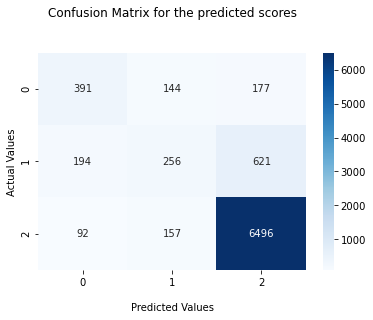

In [35]:
display_confusion_matrix(true_labels=test_sentiments, predicted_labels=lr_bow_predictions, target_names=target_names)

## TF-IDF Vectorizer

De TF-IDF Vectorizer resultaten geven net zoals de Count vectorizer een goed beeld van de accurary op de 3 mogelijke klassen. Het model scoort in dit geval `84.28%` op de sentiment analyse. In het 'Model Classification report' staan verder nog specifiekere resultaten voor elke klasse beschreven. Het model scoort zeer gelijkaardige resultaten waardbij de afgeronde waarde ook 84% bedraagt. Het positief classificeren van een tekst gaf de hoogste accuracy met `87%` voor `6745` reviews, daarop volgend met het neutraal classificeren van een tekst gaf `52%` voor `1071` reviews en het negatief classificeren gaf `67%` voor `712` reviews.

In [36]:
print('Logistic Regression model on TF-IDF')
lr_tfidf_predictions = train_predict_model(classifier=lr, train_features=tv_train_features, train_labels=train_sentiments,
                                           test_features=tv_test_features, test_labels=test_sentiments)
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_tfidf_predictions, target_names=target_names)

Logistic Regression model on TF-IDF
Model Performance metrics:
--------------------------------------------------
Accuracy:  84.29% 
Precision: 80.95% 
Recall:    84.29% 
F1 Score:  81.15% 

Model Classification report:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.50      0.57       712
           1       0.52      0.17      0.26      1071
           2       0.87      0.98      0.92      6745

    accuracy                           0.84      8528
   macro avg       0.69      0.55      0.59      8528
weighted avg       0.81      0.84      0.81      8528



### TD-IDF Vectorizer confusion matrix

In de onderstaande confusion matrix worden de voorspelde waarden met de echte waarden vergeleken. In een confusion matrix verwachten we dat er zoveel mogelijk waarden op de diagnonale eenheidsmatrix waarden liggen.

De 3 mogelijke klassen: 
- Positief: 2
- Neutraal: 1
- Negatief: 0

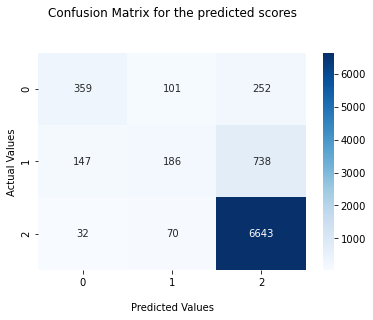

In [37]:
display_confusion_matrix(true_labels=test_sentiments, predicted_labels=lr_tfidf_predictions, target_names=target_names)

## SGD-Classifier with Count & TF-IDF Vectorizer

Deze SGD-Classifier maakt gebruik van lineaire modellen met stochastisch gradiënt descent om het minimum te vinden van een functie. De gradiënt van de loss wordt voor elke review tegelijk geschat en het model wordt door de loop van het proces bijgewerkt met een afnemend krachtenschema (leersnelheid).

In [76]:
class_weight = {0:1, 1:2, 2:2}
svm = SGDClassifier(loss='modified_huber', max_iter=1000, n_jobs=5, random_state=101, class_weight=class_weight)

De SGD classifier resultaten geven met de Count vectorizer en de TF-IDF vectorizer een goed beeld van de accurary op de 3 mogelijke klassen. Beide modellen scoren in dit geval rond de `80-84%` op de sentiment analyse. In het 'Model Classification report' staan verder nog specifiekere resultaten voor elke klasse beschreven.

In [77]:
svm_bow_predictions = train_predict_model(classifier=svm, train_features=cv_train_features, train_labels=train_sentiments,
                                            test_features=cv_test_features, test_labels=test_sentiments)
print('SGDClassifier model on BOW:')
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_bow_predictions,target_names=target_names)

svm_tfidf_predictions = train_predict_model(classifier=svm, train_features=tv_train_features, train_labels=train_sentiments,
                                            test_features=tv_test_features, test_labels=test_sentiments)
print('-'*50)
print('\nSGDClassifier model on TF-IDF:')
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_tfidf_predictions, target_names=target_names)

SGDClassifier model on BOW:
Model Performance metrics:
--------------------------------------------------
Accuracy:  79.41% 
Precision: 77.59% 
Recall:    79.41% 
F1 Score:  78.40% 

Model Classification report:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.52      0.47      0.50       712
           1       0.32      0.25      0.28      1071
           2       0.87      0.91      0.89      6745

    accuracy                           0.79      8528
   macro avg       0.57      0.55      0.56      8528
weighted avg       0.78      0.79      0.78      8528

--------------------------------------------------

SGDClassifier model on TF-IDF:
Model Performance metrics:
--------------------------------------------------
Accuracy:  84.39% 
Precision: 81.25% 
Recall:    84.39% 
F1 Score:  81.81% 

Model Classification report:
--------------------------------------------------
              precision    recall  f1-

### Count Vectorizer confusion matrix

Opnieuw wordt er een confusion matrix uitgeprint met een vergelijking tussen de voorspelde en echte waarden. Voor deze onderstaande matrix dat het Count vectorizer model weergeeft kunnen we duidelijk zien dat voor de echte en voorspelde waarde van 1 er een grote hoeveelheid als 2 (603) worden geclassificeerd. In het algemeen wordt de positieve waarde (2) het beste geclassificeerd.

De 3 mogelijke klassen: 
- Positief: 2
- Neutraal: 1
- Negatief: 0

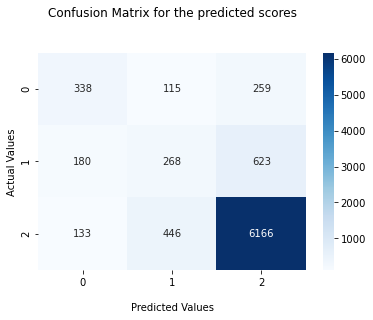

In [78]:
display_confusion_matrix(true_labels=test_sentiments, predicted_labels=svm_bow_predictions, target_names=target_names)

### TF-IDF Vectorizer confusion matrix

Opnieuw wordt er een confusion matrix uitgeprint met een vergelijking tussen de voorspelde en echte waarden. Voor deze onderstaande matrix dat het TD-IDF vectorizer model weergeeft kunnen we duidelijk zien dat voor de echte en voorspelde waarde van 1 er een grote hoeveelheid als foutieve 2 worden geclassificeerd. Bij 0 (negatief) worden er ook enkele waarden foutief geclassificeerd als 2 (positief).

De 3 mogelijke klassen: 
- Positief: 2
- Neutraal: 1
- Negatief: 0

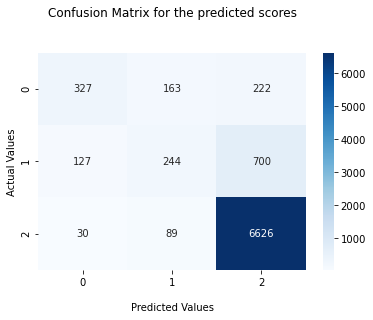

In [79]:
display_confusion_matrix(true_labels=test_sentiments, predicted_labels=svm_tfidf_predictions, target_names=target_names)

# RNN model

Recurrent neurale netwerken (RNN) zijn een klasse van neurale netwerken die krachtig zijn voor het modelleren van sequentiegegevens zoals tijdreeksen of natuurlijke talen. In het onderstaande deel wordt er een sequential model opgebouwd dat bestaat uit enkele lagen waarin de getokenizde en gecleande teksten worden aangeleverd.

In [38]:
rnndf = df.copy()
rnndf.drop(columns=['Original_Text', 'cleaned_text'], inplace=True)
rnndf

,Rating,Sentiment,Review_Text
0,4,2,"[ve, disneyland, anywhere, ll, find, disneylan..."
1,4,2,"[d, last, time, visit, hk, disneyland, yet, ti..."
2,4,2,"[thank, god, wasn, t, hot, humid, visit, big, ..."
3,4,2,"[hk, disneyland, great, compact, unfortunately..."
4,4,2,"[location, city, take, around, hour, kowlon, k..."
...,...,...,...
42631,5,2,"[go, disneyland, paris, july, think, brilliant..."
42632,5,2,"[adults, child, visit, disneyland, paris, begi..."
42633,5,2,"[eleven, year, old, daughter, go, visit, son, ..."
42634,4,2,"[hotel, part, disneyland, paris, complex, wond..."


In [39]:
reviews_data = df['Review_Text'].values.tolist()
y_sentiment = df['Sentiment'].values.tolist()

Hieronder zien we het aantal reviews voor elke sentiment waarde.

In [40]:
df.Sentiment.value_counts()

2    33905
1     5105
0     3626
Name: Sentiment, dtype: int64

In [41]:
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews_data, y_sentiment, test_size=0.3, random_state=42)

De tokens worden met de Out Of Vocab-token tokenizer omgezet, dit zal alle onbekende woorden vervangen door een token naar keuze. Dit is beter dan het weggooien van onbekende woorden, omdat het ons model vertelt dat hier informatie was. Hierna worden de teksten gesequenced (omgezet in getallen) om te kunnen gebruiken in het model.

In [42]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=True)
tokenizer.fit_on_texts(reviews_data)

rnndf['review_encoded'] = tokenizer.texts_to_sequences(reviews_data)
rnndf['length_review'] = rnndf['review_encoded'].apply(lambda x: len(x))
rnndf = rnndf[rnndf['length_review'] != 0]
rnndf

,Rating,Sentiment,Review_Text,review_encoded,length_review
0,4,2,"[ve, disneyland, anywhere, ll, find, disneylan...","[143, 5, 591, 238, 60, 5, 156, 157, 653, 1530,...",31
1,4,2,"[d, last, time, visit, hk, disneyland, yet, ti...","[210, 126, 3, 9, 225, 5, 567, 3, 58, 701, 3706...",109
2,4,2,"[thank, god, wasn, t, hot, humid, visit, big, ...","[538, 1553, 204, 6, 218, 1636, 9, 89, 412, 32,...",80
3,4,2,"[hk, disneyland, great, compact, unfortunately...","[225, 5, 12, 1457, 498, 140, 118, 642, 138, 2,...",46
4,4,2,"[location, city, take, around, hour, kowlon, k...","[850, 558, 16, 44, 105, 16256, 13, 5, 30, 85, ...",16
...,...,...,...,...,...
42631,5,2,"[go, disneyland, paris, july, think, brilliant...","[2, 5, 64, 745, 62, 410, 9, 345, 58, 1357, 797...",80
42632,5,2,"[adults, child, visit, disneyland, paris, begi...","[158, 198, 9, 5, 64, 606, 1648, 1003, 176, 3, ...",82
42633,5,2,"[eleven, year, old, daughter, go, visit, son, ...","[4839, 53, 66, 159, 2, 9, 233, 1809, 299, 2, 5...",51
42634,4,2,"[hotel, part, disneyland, paris, complex, wond...","[75, 197, 5, 64, 2321, 180, 14, 456, 13, 72, 2...",56


In [43]:
reviews_pad = pad_sequences(rnndf['review_encoded'], padding='post')

In [44]:
full_ds = tf.data.Dataset.from_tensor_slices((reviews_pad, rnndf['Sentiment'].values))

In [45]:
TAKE_SIZE = int(0.7 * rnndf.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(16)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(16)

In [46]:
for review, rating in train_data.take(1):
    print('Review feature data: \n', review)
    print('Review ratings: \n', rating)

Review feature data: 
 tf.Tensor(
[[  12   34   13 ...    0    0    0]
 [ 192  206   95 ...    0    0    0]
 [ 249   14 1075 ...    0    0    0]
 ...
 [  42   74  230 ...    0    0    0]
 [  20    3  124 ...    0    0    0]
 [ 270 1521    5 ...    0    0    0]], shape=(16, 1726), dtype=int32)
Review ratings: 
 tf.Tensor([2 2 2 2 1 1 2 2 1 2 1 2 2 2 2 2], shape=(16,), dtype=int64)


In [47]:
vocab_size = len(tokenizer.word_index)

### Model

Het model bevat een embedding laag dat vereist dat de invoergegevens integer gecodeerd zijn, zodat elk woord wordt vertegenwoordigd door een uniek getal. Vervolgens zijn er 2 convolutionele 1 dimensionale lagen gedefinieerd dat een array van getallen omzet naar een convolutionele laag van neuronen.

De rectified linear activation functie of ReLU in het kort, is een lineare functie dat de input teruggestuurd wanneer het een positief getal is en in het andere geval een 0 terug stuurt.

De Flatten laag wordt gebruikt om multidimensionale invoer eendimensionaal te maken. Deze laag wordt het meeste gebruikt bij overgangen van een convolutielaag naar een fully connected laag (Dense laag).

De output van de softmax activatie functie wordt toegewezen aan een 0 tot 1 bereik. Het brengt de output in kaart op een manier dat de totale som van alle waaren gelijk is aan 1. Op deze manier worden de probabiliteiten voor elke eindklasse aangegeven. Voor een clasificatie probleem wordt de eindlaag ingesteld op een softmax activatie functie met het aantal filters ingesteld op het aantal klassen. In dit geval zijn er 3 klasses probabiliteiten die kunnen worden voorspelt.

In [48]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, 64, input_shape=[review.shape[1],]),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.Conv1D(16, 3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')                
])

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1726, 64)          2099648   
                                                                 
 conv1d (Conv1D)             (None, 1724, 32)          6176      
                                                                 
 conv1d_1 (Conv1D)           (None, 1722, 16)          1552      
                                                                 
 flatten (Flatten)           (None, 27552)             0         
                                                                 
 dense (Dense)               (None, 64)                1763392   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                5

### Compile model

Als optimizer wordt er gekozen voor de `adam` optimizer met een learning rate als parameter dat een ExponentialDecay optimizer gebruikt. In de wiskunde beschrijft exponentieel verval (ExponentialDecay) het proces van het verminderen van een waarde met een consistent percentage over een bepaalde periode van tijd. Het kan worden uitgedrukt door de formule `y=a(1-b)x` waarin 'y' het uiteindelijke getal is, 'a' het oorspronkelijke getal is, 'b' de vervalfactor is en 'x' de hoeveelheid tijd dat verstreken is.


Als metrics worden de SparseCategoricalCrossentropy en accuracy gebruikt om het resultaat te zien van elke epoch tijdens het trainen. De SparseCategoricalCrossentropy wordt het vaakst gebruikt in NLP toepassingen, in dit geval werkt men met duizenden klassen met als doel het volgende woord te voorspellen. Deze taak levert een situatie op waarin de y_true een enorme matrix is die bijna allemaal uit nullen bestaat, een perfecte plek om een schaarse matrix te gebruiken.

In [50]:
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=2500, decay_rate=0.96, staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy', 'accuracy'])

In [51]:
class_weight = {0:1, 1:2, 2:2}

In [52]:
history = model.fit(train_data, epochs=5, validation_data=test_data, class_weight=class_weight)

Epoch 1/5
1866/1866 [==============================] - 118s 63ms/step - loss: 0.8588 - sparse_categorical_accuracy: 0.8344 - accuracy: 0.8344 - val_loss: 0.5502 - val_sparse_categorical_accuracy: 0.7576 - val_accuracy: 0.7576
Epoch 2/5
1866/1866 [==============================] - 119s 64ms/step - loss: 0.6118 - sparse_categorical_accuracy: 0.8587 - accuracy: 0.8587 - val_loss: 0.5537 - val_sparse_categorical_accuracy: 0.7704 - val_accuracy: 0.7704
Epoch 3/5
1866/1866 [==============================] - 112s 60ms/step - loss: 0.5556 - sparse_categorical_accuracy: 0.8697 - accuracy: 0.8697 - val_loss: 0.5527 - val_sparse_categorical_accuracy: 0.7759 - val_accuracy: 0.7759
Epoch 4/5
1866/1866 [==============================] - 109s 58ms/step - loss: 0.5139 - sparse_categorical_accuracy: 0.8799 - accuracy: 0.8799 - val_loss: 0.5580 - val_sparse_categorical_accuracy: 0.7716 - val_accuracy: 0.7716
Epoch 5/5
1866/1866 [==============================] - 109s 58ms/step - loss: 0.4764 - sparse_ca

Hieronder wordt het model getest op een test review uit de test dataset en geëvalueerd op de test dataset. Het resultaat is voor dit model `76.94%` met een loss van `0.5661`.

In [53]:
for review, rating in test_data.take(1):
    y_pred = model.predict(review)
    print('Prediction         : {}'.format(np.argmax(y_pred, axis=1)))
    print('Real ratings       : {}'.format(rating))
    
    score = model.evaluate(test_data, verbose=0)
    val_loss, val_acc, acc = score
    print('Validation loss    : {}'.format(str(round(val_loss, 4))))
    print('Validation accuracy: {}%'.format(str(round(val_acc * 100, 2))))

Prediction         : [2 2 2 1 2 1 2 0 0 2 1 0 2 2 2 2]
Real ratings       : [2 1 2 2 1 2 2 0 0 2 0 0 2 2 2 2]
Validation loss    : 0.5661
Validation accuracy: 76.94%


In onderstaande grafiek worden de loss en validation loss vergeleken met elkaar. Hieruit zien we dat de loss tijdens het trainen (blauw) harder daalt dan tijdens het testen. De loss waarden moet voor beide zo laag mogelijk zijn.

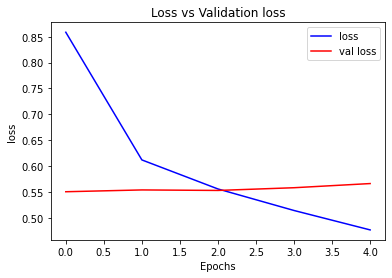

In [54]:
# Visualization of the training process on the loss function 
plt.plot(history.history['loss'], color='b')
plt.plot(history.history['val_loss'], color='r')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['loss', 'val loss'])
plt.title('Loss vs Validation loss')
plt.show()

De sparse category accuracy stijgt tijdens het trainen veel hoger dan de test accuracy (0.84 - 0.88) tegenover de lagere validation accuracy dat maar tot maximaal 0.78 gaat.

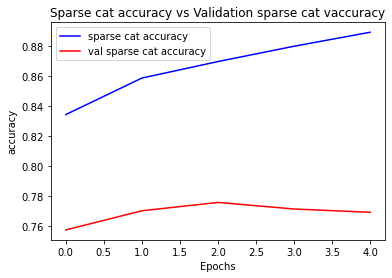

In [55]:
# Visualization of accuracy training 
plt.plot(history.history['sparse_categorical_accuracy'], color='b')
plt.plot(history.history['val_sparse_categorical_accuracy'], color='r')
plt.ylabel('accuracy')
plt.xlabel('Epochs')
plt.legend(['sparse cat accuracy', 'val sparse cat accuracy'])
plt.title('Sparse cat accuracy vs Validation sparse cat vaccuracy')
plt.show()

### RNN model prediction confusion matrix

De confusion matrix voor het RNN model print een vergelijking tussen de voorspelde en echte waarden uit. Deze matrix toont aan dat het model vrij goed scoort op de test dataset net zoals in de andere modellen dit het geval is. Deze bias naar de positieve waarden toe (2) kan hoofdzakelijk komen omdat meer dan 79.53% (25.26% + 54.27%) een positieve review is. Er zijn ook heel wat woorden dat voorkomen in beide reviews wat het sentiment alleen maar meer naar het positieve kan duwen.

De 3 mogelijke klassen: 
- Positief: 2
- Neutraal: 1
- Negatief: 0

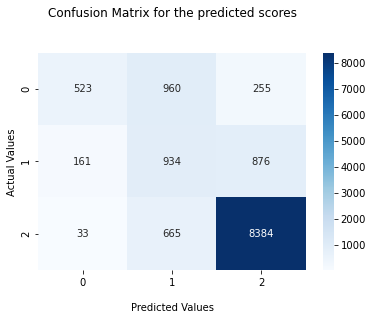

In [58]:
y_pred = model.predict(test_data)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in test_data], axis=0)

display_confusion_matrix(true_labels=true_categories, predicted_labels=predicted_categories, target_names=target_names)

### Stap 4 : Conclusie

Becommentarieer je 3 gebruikte methodes en motiveer de keuzes die je gemaakt hebt. Maak een vergelijking tussen de methodes en geef aan waarom een methode volgens jou minder / beter presteert.

## Overzicht scores alle modellen


| Algoritme    | Accuracy
|-----------|:--------:
|  VADER Model | **73.41%**
|  BOW - Count Vectorizer met Log Reg | **83.76%**
|  BOW - TF-IDF Vectorizer met Log Reg | **84.29%**
|  BOW - Count Vectorizer met SGDClassifier | **79.41%**
|  BOW - TF-IDF Vectorizer met SGDClassifier | **84.39%**
|  RNN - Sequential model met Out Of Vocab-token tokenizer | **76.94%**

## VADER Model

Het eerste model presteert in het algemeen een score van 73.41%. Er is duidelijk een positief sentiment te vinden met het VADER model omdat ongeveer 80% positieve reviews zijn, hierdoor is er een grotere overfitting richting het positieve/neutrale sentiment voor de negatieve reviews. Omdat het model al getrained is op teksten is het niet mogelijk om nog veel opties te wijzigen, hierdoor kan er overfitting optreden richting bepaalde woorden en zinnen die in de trainingsset aanwezig waren.

## Bag-of-Words technieken

Beide Bag-Of-Words modellen doen het best goed op de reviews. Het logistic regression model heeft voor de Count Vectorizer `83.76%` behaald en voor het TF-IDF model een net iets hogere score van `84.29%`. Deze modellen scoren ook meteen het hoogste dankzij het omzetten van teksten naar een vectorrepresentatie. Aan de scores te zien is TF-IDF beter dan de Count Vectorizer methode, omdat het niet alleen focust op de frequentie van woorden die voorkomen in de dataset, maar ook het belang van de woorden representeert.

Naast de Count en TF-IDF Vectorizer heb ik ook de technieken toegepast op een SGDClassifier met stochastisch gradiënt descent om de beide modellen te optimaliseren. Uit de resultaten blijkt dat beide technieken ongeveer het zelfde resultaat leveren. Het Count Vectorizer model met SDG doet het net iets minder goed (79%) dan het TF-IDF Vectorizer model met een gelijke score van `84%`.

## RNN Model

Het RNN model maakt gebruik van gevectorizeerde tensor slices om op te trainen. Het model gaf een score van afgerond `77%` wat het in het algemeen en klein beetje minder goed deed dan de andere modellen.
We analyseerden de confusion matrixen van 5 classifiers op basis van hun classificatieprestaties op `8528` test review teksten. Er werden `8384` documenten correct als positief (2) gelabeld waarbij er voor elk model telkens een klein aantal reviews fout werden geclassificeerd. Deze bias komt voornamelijk uit de hoge positiviteitsgraad in de gehele dataset.

Alle modellen maakten gebruik van labels die omgevormd zijn naar 3 mogelijke keuzes (positief, negatief, neutraal). De initiële scores waren een natuurlijk getal tussen 1 en 5. Dit zou voor elk model een moeilijkere taak zijn om de probabiliteit voor elke review te gaan verdelen tussen 5 mogelijkheden. Door het aantal probabiliteiten te verkleinen is de kans op fouten maken kleiner en stijgt de algemene score van het model. Er zou ook kunnen gekozen worden voor een binair (positief, negatief) classificatie model maar dit zou het probleem niet geheel oplossen omwille van het hoge aantal positieve reviews.